# Parsing FlockLab Link Quality Test Results

| **Author** |**Last modified**|
|:---:|:---:|
|Romain Jacob  |17-11-2019|

This notebook describes and performs the parsing of the raw data for the link quality tests run on FlockLab. Most of the code would be reusable for parsing results collected on other networks, but one would have to adapt some of the parsing to the specific serial log format.

The rationale about the collection of this dataset is described in the following abstract. 
> **Dataset: Wireless Link Quality Estimationon FlockLab – and Beyond**  
Romain Jacob, Reto Da Forno, Roman Trüb, Andreas Biri, Lothar Thiele   
DATA '19 Proceedings of the 2nd Workshop on Data Acquisition To Analysis, 2019  
[Direct link](https://www.research-collection.ethz.ch/handle/20.500.11850/355846)

The entire dataset is openly available on Zenodo. The repository contains the collected raw measurement data and other related files, including this notebook and the abstract.  
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3354717.svg)](https://doi.org/10.5281/zenodo.3354717)

The plots from the abstract can be found (in interactive version) in the notebook:
- [Figure 1](#Figure-1)
- [Figure 2a](#Figure-2a)
- [Figure 2b](#Figure-2b)

In [5]:
import os
import re
import csv
import numpy as np 
import pandas as pd
from pathlib import Path
import datetime

## Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "none"
pio.renderers.default = "notebook"

In [2]:
# -----------------------------------------------------------------------------------------------------------------
# Parameter settings
# -----------------------------------------------------------------------------------------------------------------
# Targets to parse
targets = {'sky','dpp-cc430'}

# Month to process
month = '2019-10'

# Path to results to parse
data_root_folder = Path("data_raw")

# Expected list of node ids
node_list = [1, 2, 3, 4, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]

# Number of strobes sent
number_of_strobes = 100

# Custom file name prefix (optional)
result_file_prefix = Path("data_preprocessed")
result_file_prefix = result_file_prefix / month 

# Create corresponding directory
if not os.path.exists(str(result_file_prefix)):
    os.mkdir(str(result_file_prefix))

result_file_prefix = result_file_prefix / str(month+'_')


# Enable/Disable verbose print information
verbose_print = 0
# -----------------------------------------------------------------------------------------------------------------

In [16]:
# -----------------------------------------------------------------------------------------------------------------
# Parsing routine
# -----------------------------------------------------------------------------------------------------------------
for target in targets:
    
    print("%s\t Processing..." % target)
    
    data_folder = data_root_folder / target / month
    
    # Set the result file name
    result_file = str(result_file_prefix)+'FlockLab_'+target+'.csv'

    # Create the result file and write the header line
    with open(result_file, 'w',newline='') as csvfile:
        result_writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow([
            'date_time', 
            'test_number', 
            'rf_channel',  
            'tx_power',  
            'payload', 
            'host_id', 
            'random_seed', 
            'snd_id', 
            'rcv_id', 
            'rcv_total',
            'rcv_stream',
        ])
      
    # Set the data folder and list of test dates  
    data_folder = data_root_folder / target / month
    date_list = np.array(os.listdir(str(data_folder)))
    mask = np.array([os.path.isdir(os.path.join(str(data_folder), date)) for date in date_list])
    date_list = date_list[mask]
    
    # Loop through the tests and parse the serial log file
    for test_date in sorted(date_list)[:-2]: # the last two days are not yet available

        # Open and read again the test scheduling log
        sum_file_name = "sched_log.txt"
        sum_file = data_folder / test_date / sum_file_name
        g = open( str(sum_file), "r")
        line = g.readline()
        
        # Create a clean tmp output file
        h = open('tmp_output.txt', 'w')
        h.close()

        while line != '':

            if "Test ID" in line:
                # Get test number
                tmp = line.split(':')
                (test_number,tmp) = tmp[1].split(',')
                test_number = int(test_number)

                # Get test datetime
                tmp = line.split(' ')
                test_datetime = tmp[7]

                # Open the test serial log
                try: 
                    f = open( str(data_folder / test_date)+'/' + str(test_number) + "/serial.csv" , 
                             "r",
                             errors='ignore')
                    result_file_exist = 1
                except FileNotFoundError: 
                    result_file_exist = 0
                    if verbose_print:
                        print("%s / %s / %g : %s"
                              % (target,
                                 test_date,
                                 test_number,
                                 'Results not found (failed or not yet fetched)'
                                ))
                    
                # Get test metadata from the FlockLab xml config file
                if result_file_exist:
                    
                    # Reset the storing variables
                    (rf_channel,  
                    tx_power,  
                    host_id,  
                    test_payload, 
                    random_seed) = '','','','',''
                            
                    # Parse the XML file
                    file_name = str(data_folder / test_date)+'/'+ str(test_number)+'/testconfiguration.xml'
                    with open(file_name, 'r') as xml_file: 
                        for line in xml_file:
                            if 'RF_CH' in line:
                                tmp = line[0:-1].split('=')
                                rf_channel = int(tmp[1])
                            if 'TX_PW' in line:
                                tmp = line[0:-1].split('=')
                                tx_power = int(tmp[1])
                            if 'HOST' in line:
                                tmp = line[0:-1].split('=')
                                host_id = int(tmp[1])
                            if 'PAYLOAD' in line:
                                tmp = line[0:-1].split('=')
                                test_payload = int(tmp[1])
                            if 'SEED' in line:
                                tmp = line[0:-1].split('=')
                                random_seed = int(tmp[1])
                            if '</description>' in line:
                                # end of the description field
                                break
                                
                    # Manually add missing data from the metadata
                    # -> Data is now included in new test results
                    # -> Line kept for re-parsing initial tests (Jul-Aug 2019)
                    if tx_power == '':
                        tx_power = 0 # 0dBm is default TX power

                # Initialized list of failed nodes during for this test
                failed_node_list = []
                
                # Loop through the list of nodes
                for node_id in node_list:
                    if result_file_exist:

                        # Re-start reading the serial file from the top
                        f.seek(0, 0)

                        # Reset tracking counters
                        snd_counter = len(node_list) 
                        # -> To stop parsing the file once all data from `node_id` has been read
                        scheduled_to_strobe = 0
                        # -> Mark that the `node_id` has been sending its stobes
                        slot_failed_counter = 0
                        # -> Track the number of failed slots

                        # Read serial log first line
                        line = f.readline()
                        
                        while line != '' and snd_counter !=0: 
                            
                            # Discard the header line
                            if line[0]=='#':
                                line = f.readline()
                                continue

                            tmp = line[0:-1].split(',')

                            if int(tmp[2]) == node_id:

                                # Reset the storing variables
                                (src_id,  
                                rcv_total,
                                rcv_stream) = '','',''
                                    
                                # Parse the data from the serial log
                                if "Log:" in tmp[4]:

                                    if "Strobing" in tmp[4]:
                                        # Flag when `node_id` has been strobing 
                                        scheduled_to_strobe = 1
                                        snd_counter -= 1
                                        line = f.readline()
                                        continue

                                    if "Err!" in tmp[4]:
                                        # Slot failed! Get `src_id` and set number of strobes received to null
                                        slot_failed_counter += 1
                                        (tag, src_id, rcv_total) = tmp[4].split(':')
                                        rcv_total = ''
                                        rcv_stream_string = ''

                                    else:
                                        # Get the `src_id` and strobes reception data
                                        try:
                                            (tag, src_id, rcv_total, rcv_stream) = tmp[4].split(':')
                                            rcv_stream = rcv_stream.split('.')
                                            rcv_stream_string = ''
                                            for byte in rcv_stream[:-1]:
                                                rcv_stream_string+='{0:08b}'.format(int(byte))

                                        except ValueError:
                                            print('caught encoding error')
                                            slot_failed_counter += 1
                                            rcv_total = ''
                                            rcv_stream_string = ''
                                        
                                    # Save test data in tmp file
                                    with open('tmp_output.txt', 'a', newline='') as csvfile:
                                        result_writer = csv.writer(csvfile, 
                                                                   delimiter=',', 
                                                                   quotechar='|', 
                                                                   quoting=csv.QUOTE_MINIMAL)
                                        result_writer.writerow([
                                            test_datetime,
                                            test_number, 
                                            rf_channel,  
                                            tx_power,  
                                            test_payload, 
                                            host_id, 
                                            random_seed, 
                                            src_id, 
                                            node_id, 
                                            rcv_total,
                                            rcv_stream_string[:-(number_of_strobes%8)],
                                        ])

                                    # Decrement the counter
                                    snd_counter -= 1

                            # Read the next lime
                            line = f.readline()

                        # Mark list of failed nodes
                        if scheduled_to_strobe != 1:
                            # `node_id` did not strobe 
                            failed_node_list.append(node_id)
                            if verbose_print:
                                print('%s / %s / %g : %s' 
                                     % (target,
                                        test_date,
                                        test_number,
                                        'Node '+str(node_id)+' failed'
                                       ))

                        if slot_failed_counter != 0:
                            # `node_id` had some failed slots, something went wrong...
                            if verbose_print:
                                print('%s / %s / %g : %s' 
                                     % (target,
                                        test_date,
                                        test_number,
                                        'Node '+str(node_id)+' failed, '+str(slot_failed_counter)+' slots failed'
                                       ))
                            # if all slots failed, mark the node as failed
                            if slot_failed_counter == (len(node_list)-1):
                                failed_node_list.append(node_id)

                # Close serial file
                if result_file_exist:
                    f.close()
                
                # All nodes but the host failed, discard the test
                if len(failed_node_list) == (len(node_list)-1):
                    if verbose_print:
                        print(target+" / "+test_date+" / "+str(test_number)+" : All nodes failed, test discarded.")
                    continue
                
                # Write test data to the global result file    
                with open(result_file, 'a') as outfile:
                    
                    # Read tmp output file and clean failed nodes data
                    with open('tmp_output.txt', 'r') as tmp_file:
                        
                        # Prepare replacement data
                        rcv_stream_string = ''
                        for i in range(number_of_strobes):
                            rcv_stream_string += '0'
                        
                        # Read tmp output file
                        tmp_data = tmp_file.read()
                        
                        # Loop through failed nodes and replace corresponding data
                        for src_id in failed_node_list:
                            for dest_id in node_list:
                                old_line = ',%g,%g,.*' % (float(src_id),float(dest_id))
                                new_line = ',%g,%g,' % (src_id,dest_id)
                                tmp_data = re.sub(old_line, new_line, tmp_data)
                                
                        # Write cleaned test data to the global result file
                        outfile.write(tmp_data)
                        
            # Move on to the next test 
            line = g.readline()

        # Clean-up
        g.close()
        os.remove('tmp_output.txt')
        
    print("%s\t Done." % target)

dpp-cc430	 Processing...
dpp-cc430	 Done.
sky	 Processing...
sky	 Done.


The raw data is now parsed and available easily from the `.cvs` files. We wrote simple routines to extract and plot two information from the `.csv` files: a connectivity map for the FlockLab network, and the time series of average link quality.

## FlockLab connectivity map

From the pre-processed `.csv` files, it is easy to compute a connectivity matrix for the FlockLab network. 

The numerical values in our matrix are the **median number of strobes** received across all tests.  
Grey squares indicate that there is no data available for the corresponding `source <-> destination` pair.

In [17]:
def plot_connectivity_matrix(data_file, plot_title='', slice_size=0):

    # Input check
    if not isinstance(data_file, str):
        raise ValueError("Wrong input type. Expect a string, got "+repr(data_file)+".")

    # Import csv into dataframe
    try: 
        df = pd.read_csv(data_file, delimiter=',', error_bad_lines=False)
    except FileNotFoundError: 
        print(repr(data_file) + " not found")

    # Keep only the relevant columns
    df = df[['snd_id','rcv_id','rcv_total']]

    # Create an empty DataFrame to hold the connectivity map data
    connect_matrix = pd.DataFrame(np.nan, index=node_list, columns=node_list)
    connect_matrix.index.name = 'Sender node ID'

    # Fill the DataFrame
    for snd_id in node_list:
        for rcv_id in node_list:
            data = df.loc[(df['snd_id'] == snd_id) & (df['rcv_id'] == rcv_id)].median()[2]
            connect_matrix.at[snd_id, rcv_id] = data

    # Select a subset of the matrix for ploting
    if slice_size:
        connect_matrix = connect_matrix.loc[:slice_size,:slice_size]
    
    # Output the map
    mask = connect_matrix.isnull()
    ax = plt.axes()
    if plot_title == '':
        ax.set_title('FlockLab connectivity matrix', fontsize=22)
    else:
        ax.set_title(plot_title, fontsize=20)
    ax = sns.heatmap(connect_matrix, mask=mask, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Receiver node ID', fontsize=16)
    ax.set_ylabel('Sender node ID', fontsize=16)

### Figure 1

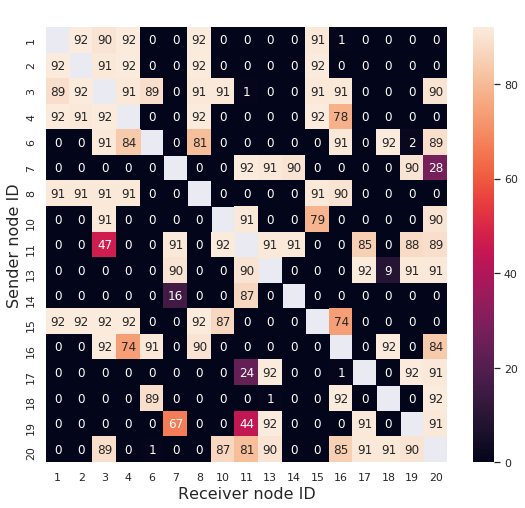

In [18]:
month = '2019-07'
result_file_prefix = Path("data_preprocessed")
result_file_prefix = result_file_prefix / month
data_file = result_file_prefix / str(month+'_FlockLab_dpp-cc430.csv')

# Set `abstract_plot` to True to generate the plot used in the abstract
# Set `abstract_plot` to False to generate the entire map
abstract_plot = True

if abstract_plot:
    sns.set(rc={'figure.figsize':(9,8)})
    plot_connectivity_matrix(str(data_file), plot_title=' ', slice_size=20)
else:
    sns.set(rc={'figure.figsize':(14,12)})
    plot_connectivity_matrix(str(data_file), plot_title='FlockLab connectivity matrix - DPP-cc430 - CH5')

> **Figure 1: (Partial) FlockLab connectivity matrix for theTelosB platform.** The matrix shows the median number of strobesreceived between each pair of nodes in tests run in July 2019. Forvisibility, we limit the visualization to node 1 to 20.

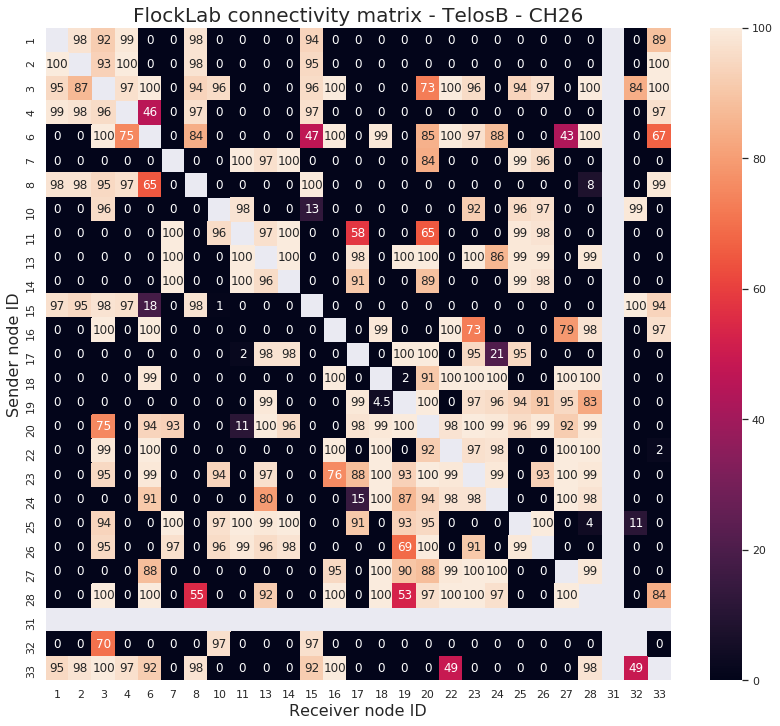

In [19]:
month = '2019-07'
result_file_prefix = Path("data_preprocessed")
result_file_prefix = result_file_prefix / month
data_file = result_file_prefix / str(month+'_FlockLab_sky.csv')

sns.set(rc={'figure.figsize':(14,12)})
plot_connectivity_matrix(str(data_file), plot_title='FlockLab connectivity matrix - TelosB - CH26')

## Average link quality time series

From the pre-processed `.csv` files, it is also easy to plot a time series for some given metric.

As an example, we wrote a routine that plot a time series of **average link quality**.  
We define such an average by considering only links where the number of strobes received is above a given threshold (e.g., 50 - out of 100), then taking the mean of the number of strobes received between all `source <-> destination` pairs.

**Note.** This definition of average link quality is arbitrary, and only serves as illustration.

In [3]:
def plot_link_quality_series(data_file_list, active_threshold, plot_title='', plot_size=[], out_name=None):
     
    # Import csv into dataframe
    li = []
    for data_file in data_file_list:
        try: 
            df_tmp = pd.read_csv(data_file, delimiter=',', error_bad_lines=False)
            li.append(df_tmp)
        except FileNotFoundError: 
            print(repr(data_file) + " not found")

    df = pd.concat(li, axis=0, ignore_index=True)
        
    # Parse dates
    df['date_time'] = pd.to_datetime(df['date_time'], utc=True)
    # Set date as index
    df.set_index('date_time', inplace=True)
    
    
    # Compute the averate link quality
    df.loc[df['rcv_total'] < active_threshold]= np.nan
    df = df.groupby('date_time')['rcv_total'].mean()

    
    # Initialize the figure
    figure = go.Figure()
    
    # Create the traces to plot
    trace = go.Scatter(
        name='Data',
        x=df.index,
        y=df,
        mode='markers'
    )
    figure.add_trace(trace)
    
    # Generate the shapes to shade the weekends
    dates = np.unique(df.index.date)
    weekends = []
    shades = []
    opacity=0.5
    for date in dates:
        if date.weekday() == 5:
            weekends.append(date)
    for weekend in weekends:
        shade = {
                    'type': 'rect',
                    'layer': 'below',
                    # x-reference is assigned to the x-values
                    'xref': 'x',
                    # y-reference is assigned to the plot paper [0,1]
                    'yref': 'paper',
                    'x0': weekend,
                    'y0': 0,
                    'x1': weekend + datetime.timedelta(2,0),
                    'y1': 1,
                    'fillcolor': '#d3d3d3',
                    'opacity': opacity,
                    'line': {
                        'width': 0,
                    }
                }
        shades.append(shade)
            
    # Layout
    if not plot_title == '':
        title_to_plot = plot_title
    else:
        title_to_plot = 'FlockLab average link quality'
    layout = go.Layout(
        title=title_to_plot,
        yaxis={'title':'Average link quality [# strobes received]'},
        shapes=shades,
        margin=dict(l=55, r=0, t=0, b=30),
    )
    
    figure.update_layout(layout) 
    if len(plot_size):
        figure.update_layout(
            width=plot_size[0],
            height=plot_size[1])

    # Output
    figure.show()
    if out_name is not None:
        figure.write_image(out_name)
    
    return df

### Figure 2a

In [8]:
# Set `abstract_plot` to True to generate the plot used in the abstract
# Set `abstract_plot` to False to generate the entire map
abstract_plot = False

active_threshold = 50
months = ['2019-07', '2019-08', '2019-09', '2019-10']
# months = ['2019-09']
data_file_list = []
out_name = Path('plots')
out_name = str(out_name / 'FlockLab_TimeSeries_dpp-cc430.pdf')
for month in months:
    result_file_prefix = Path("data_preprocessed")
    result_file_prefix = result_file_prefix / month
    data_file = result_file_prefix / str(month+'_FlockLab_dpp-cc430.csv')
    data_file_list.append(str(data_file))


if abstract_plot:
    data_file_list = [data_file_list[0]] # Plot 2019-07 only
    plot_title=' '
    df = plot_link_quality_series(data_file_list, active_threshold, plot_title=plot_title, plot_size=[450,275], out_name=out_name)
else:
    plot_title = 'DPP-cc430 mote - FlockLab - CH5 - 0dBm'
    df = plot_link_quality_series(data_file_list, active_threshold, plot_title=plot_title, out_name=None)

> **Figure 2a: TelosB.** Channel26(2.48 GHz), 8-bytes payload, 0dBm TX power

### Figure 2b

In [11]:
# Set `abstract_plot` to True to generate the plot used in the abstract
# Set `abstract_plot` to False to generate the entire map
abstract_plot = False

active_threshold = 50
months = ['2019-07', '2019-08', '2019-09']
data_file_list = []
out_name = Path('plots')
out_name = str(out_name / 'FlockLab_TimeSeries_sky.pdf')
for month in months:
    result_file_prefix = Path("data_preprocessed")
    result_file_prefix = result_file_prefix / month
    data_file = result_file_prefix / str(month+'_FlockLab_sky.csv')
    data_file_list.append(str(data_file))

if abstract_plot:
    data_file_list = [data_file_list[0]] # Plot 2019-07 only
    plot_title=' '
    df = plot_link_quality_series(data_file_list, active_threshold, plot_title=plot_title, plot_size=[450,275],out_name=out_name)
else:
    plot_title = 'Sky mote - FlockLab - CH26 - 0dBm'
    df = plot_link_quality_series(data_file_list, active_threshold, plot_title=plot_title, out_name=None)

> **Figure 2b: DPP-cc430.** Channel5(869 MHz), 8-bytes payload, 0dBm TX power.